In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score

# 딥러닝 모델 (TensorFlow)
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

# TensorFlow GPU 가속 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU 가속 활성화됨!")
else:
    print("⚠️ GPU를 감지할 수 없습니다. CPU에서 실행됩니다.")

✅ GPU 가속 활성화됨!


##### 데이터 로드 및 UID 처리

In [ ]:
train_df = pd.read_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/train.csv")
test_df = pd.read_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FISA_기술세미나/Data/train.csv'

##### 범주형 변수 처리 (라벨 인코딩 & 원-핫 인코딩)

In [ ]:
categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
label_enc = LabelEncoder()
X["현재 직장 근속 연수"] = label_enc.fit_transform(X["현재 직장 근속 연수"])
test_df["현재 직장 근속 연수"] = label_enc.transform(test_df["현재 직장 근속 연수"])

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=False)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=False)

##### 수치형 변수 변환 (로그 변환 적용)

In [ ]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

##### 결측값 처리

In [ ]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

##### 데이터 스케일링 (StandardScaler 적용)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

##### 불균형 데이터 처리 (SMOTE 적용)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

##### 모델 정의 / 학습 / 평가

🔄 Fold 1 시작
Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5081 - loss: 0.7300 - val_accuracy: 0.4951 - val_loss: 0.6994
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5009 - loss: 0.7165 - val_accuracy: 0.4947 - val_loss: 0.6899
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5035 - loss: 0.7097 - val_accuracy: 0.5049 - val_loss: 0.6837
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5120 - loss: 0.7015 - val_accuracy: 0.5209 - val_loss: 0.6789
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5301 - loss: 0.6940 - val_accuracy: 0.5542 - val_loss: 0.6747
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5260 - loss: 0.6931 - val_accuracy: 0.5892 - val_loss: 0.6710
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5446 - loss: 0.6897 - val_accuracy: 0.6187 - val_loss: 0.6676
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5525 - loss: 0.684

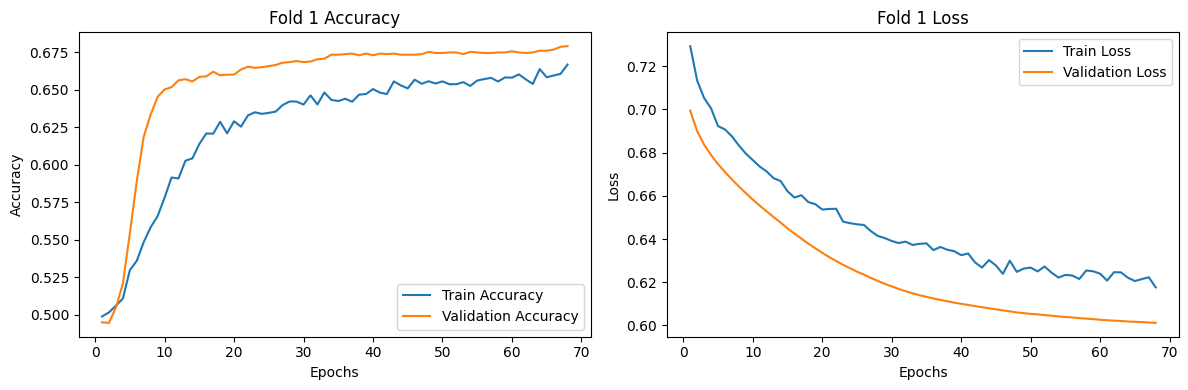

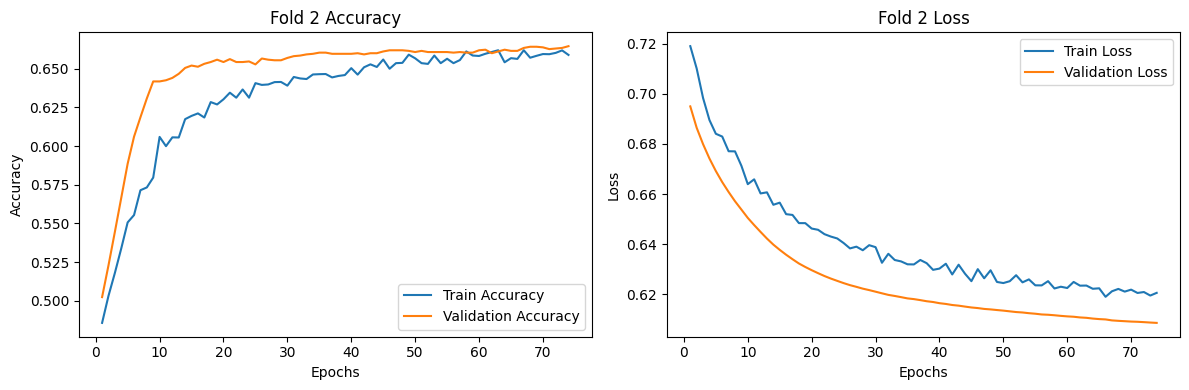

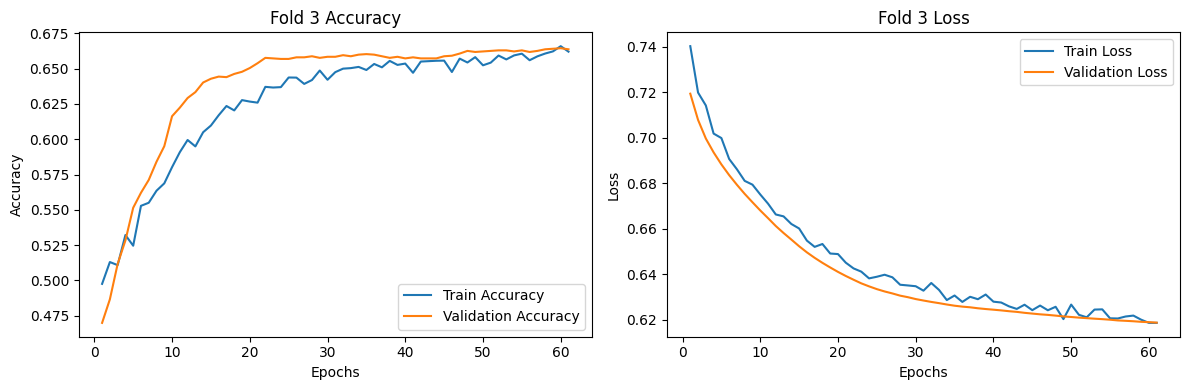

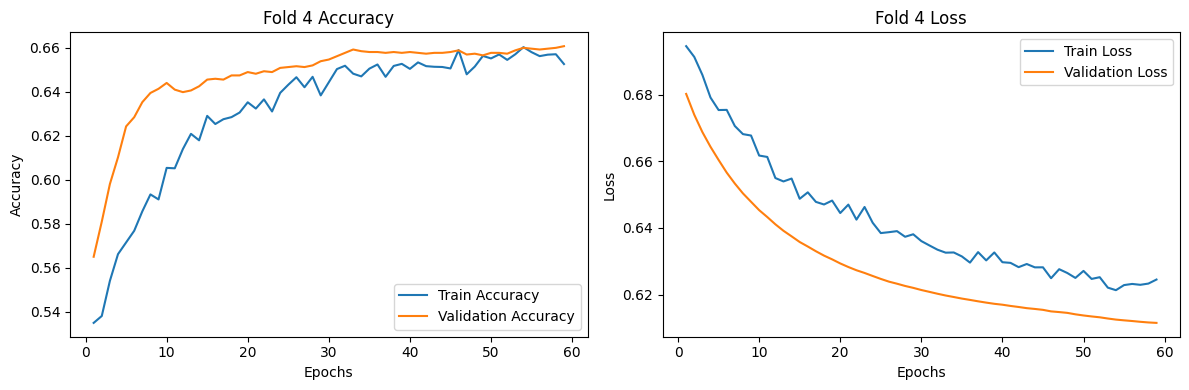

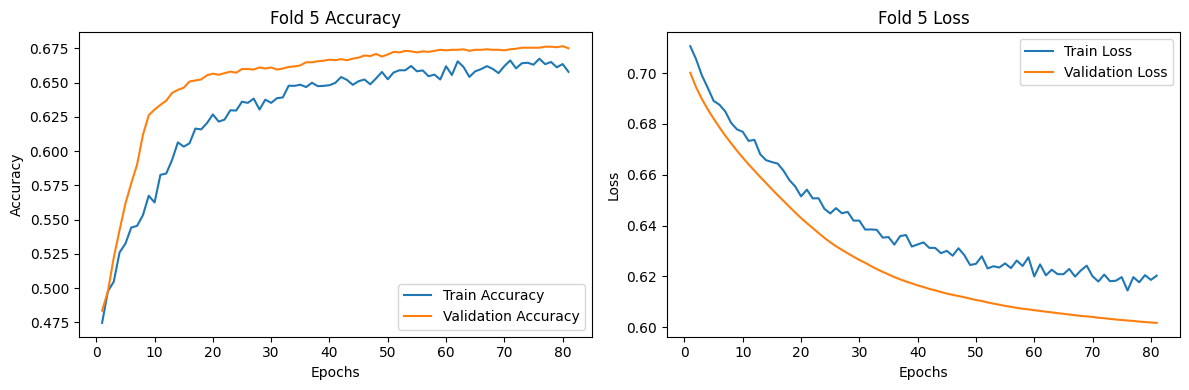

In [ ]:
# Fold별 Accuracy와 Loss 저장용 리스트 초기화
all_history = []  # 이 줄을 추가하여 all_history를 명확히 초기화합니다.

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"🔄 Fold {fold} 시작")

    # 학습/검증 데이터 분리
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    # 모델 정의
    model = keras.Sequential([
        keras.layers.Dense(128, activation="relu", input_shape=(X_train_fold.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_valid_fold, y_valid_fold),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fold의 학습 결과 저장
    all_history.append(history.history)  # Fold별 학습 결과 저장

    # 검증 데이터 예측 및 평가
    y_valid_pred = model.predict(X_valid_fold).flatten()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold {fold} Validation ROC-AUC: {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

# 교차검증 평균 결과 출력
print(f"✅ 교차검증 평균 ROC-AUC: {np.mean(roc_auc_scores):.4f}")

# 시각화: Fold별 Accuracy와 Loss
for i, history in enumerate(all_history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

##### 모델 통째로 저장

In [ ]:
model.save(r"/content/drive/MyDrive/FISA_기술세미나/model_info/my_model.keras")

In [ ]:
# 모델 불러오기
model = keras.models.load_model(r"/content/drive/MyDrive/FISA_기술세미나/model_info/my_model.keras")

##### 테스트 데이터 예측 (확률 예측)

In [ ]:
y_test_pred = model.predict(test_scaled).flatten()  # 확률 값 그대로 사용

# 제출 파일 생성
submission = pd.DataFrame({
    "UID": test_uid["UID"],
    "채무 불이행 확률": y_test_pred  # 확률값을 그대로 저장
})

# CSV 저장
submission.to_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/submission_17th.csv", index=False)

print("✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.


In [ ]:
# 전처리 완료 된 테스트 데이터 셋 저장
test_scaled_df = pd.DataFrame(test_scaled)
test_scaled_df.columns = X.columns
test_scaled_df.to_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/test_scaled.csv", index=False)

#### LIME 도입

In [ ]:
# 필요한 라이브러리 설치 및 임포트
!pip install lime
from lime.lime_tabular import LimeTabularExplainer
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

In [ ]:
# 테스트 데이터 예측 결과 csv 파일
submission_df = pd.read_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/submission_17th.csv")

In [ ]:
# LIME 설명기 생성
explainer = LimeTabularExplainer(
    training_data=test_scaled_df.values,
    feature_names=test_scaled_df.columns,
    class_names=["0", "1"],  # 클래스 이름 지정
    mode="classification"  #
)

In [ ]:
# 모델의 predict 메서드를 수정하여 두 클래스에 대한 확률을 모두 반환하도록 함.
def predict_proba(X):
    preds = model.predict(X)
    return np.column_stack([1 - preds, preds])

# 진행 상황을 표시할 progress bar 생성
total_instances = len(test_scaled_df)
progress_bar = tqdm(total=total_instances, desc="LIME 처리 중")

# 전체 테스트 데이터에 대해 반복적으로 설명 생성
all_lime_results = []

for idx in range(total_instances):
    explanation = explainer.explain_instance(
        data_row=test_scaled_df.iloc[idx].values,
        predict_fn=predict_proba,
        num_features=5
    )
    lime_results = explanation.as_list()
    lime_df = pd.DataFrame(lime_results, columns=["Feature", "Weight"])
    lime_df["Instance_ID"] = submission_df.loc[idx, "UID"]
    all_lime_results.append(lime_df)

    # Progress bar 업데이트
    progress_bar.update(1)

# Progress bar 종료
progress_bar.close()

# 최종 결과를 하나의 데이터프레임으로 결합
final_lime_df = pd.concat(all_lime_results, ignore_index=True)

LIME 처리 중:   0%|          | 0/2062 [00:00<?, ?it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━

In [ ]:
# 저장
final_lime_df.to_csv(r"/content/drive/MyDrive/FISA_기술세미나/Data/lime_df_column5.csv", index=False)

In [ ]:
final_lime_df[final_lime_df['Instance_ID'] == 'TEST_0008']
# Feature: 모델이 예측에 사용한 입력 데이터의 특정 특성
# Weight: 해당 특성이 모델 예측에 미치는 영향의 크기와 방향을 나타냄.
    ## 양수(+) 값: 해당 특성이 현재 예측 클래스(예: "1")를 지지하는 방향으로 영향을 미침.
    ## 음수(-) 값: 해당 특성이 반대 클래스(예: "0")를 지지하는 방향으로 영향을 미침.

,Feature,Weight,Instance_ID
40,대출 목적_의료비 <= -0.13,0.218725,TEST_0008
41,대출 목적_자동차 구매 <= -0.10,0.188882,TEST_0008
42,최대 신용한도 > -0.08,-0.160020,TEST_0008
43,개설된 신용계좌 수 > 0.38,0.136068,TEST_0008
44,대출 목적_주택 개보수 <= -0.32,0.098465,TEST_0008


In [ ]:
submission_df.loc[submission_df['채무 불이행 확률'].idxmin()]

,8
UID,TEST_0008
채무 불이행 확률,0.0
